<a href="https://colab.research.google.com/github/miatia1025/sim-using-tagger/blob/main/sim_using_tagger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 爆破用

In [23]:
# @markdown #💣削除用！注意！  
# @markdown 例 : `/content/test`で`/content/test`を中身ごと削除  
import shutil
dir = "/content/aaaa" # @param{type:"string"}
shutil.rmtree(dir)

In [24]:
%cd /content/

/content


# Main

In [16]:
# git lfs initializer
# @markdown <hr>

# @markdown ##Install Requirements
# @markdown <hr>

# @markdown #🐍pip Area

!pip install onnxruntime
!pip install numpy
!pip install opencv-python
!pip install python-utils
!pip install icecream

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
# git lfs initializer
# @markdown <hr>

# @markdown ##Definitions
# @markdown <hr>

# @markdown #🌱Initializer Area

home_dir = "/content"
%cd {home_dir}

import os
where_to_download_img = "/content/aaaa" #@param {type:"string"}
if not os.path.exists(where_to_download_img):
    os.makedirs(where_to_download_img)

where_to_download_model = "/content/bbbb" #@param {type:"string"}
if not os.path.exists(where_to_download_model):
    os.makedirs(where_to_download_model)


## Definitions
import onnxruntime as rt
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import cv2
import numpy as np
import io
from base64 import b64encode
from IPython.display import HTML
from icecream import ic

def smart_imread(img, flag=cv2.IMREAD_UNCHANGED):
    if img.endwith(".gif"):
        img = Image.open(img)
        img = img.convert("RGB")
        img = cv2.cvtColor(np.array(img), cv2.COLOR_BAYER_BG2BGR)
    else:
        img = cv2.imread(img, flag)
    return img

def smart_24bit(img):
    if img.dtype is np.dtype(np.uint16):
        img = (img/257).astype(np.uint8)

    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    elif img.shape[2] == 4:
        trans_mask = img[:,:,3] == 0
        img[trans_mask] = [255,255,255,255]
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

    return img

def make_squire(img, target_size):
    old_size = img.shape[:2]
    desired_size = max(old_size)
    desired_size = max(desired_size, target_size)

    delta_w = desired_size - old_size[1]
    delta_h = desired_size - old_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    
    color = [255,255,255]
    new_img = cv2.copyMakeBorder(
        img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )

    return new_img

def smart_resize(img, size):
    if img.shape[0] > size:
        img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
    elif img.shape[0] < size:
        img = cv2.resize(img, (size, size), interpolation=cv2.INTER_CUBIC)
    return img

def get_img_list(dir):
    img_path_list = []
    patterns = (".png", ".jpg", ".jpeg", ".PNG", ".JPEG", ".JPG")

    for file in glob.glob(f"{dir}/*"):
        ext = os.path.splitext(os.path.basename(file))[1]
        if ext in patterns:
            img_path_list.append(file)
    img_filename_list = [os.path.splitext(os.path.basename(item))[0] for item in img_path_list]

    return sorted(img_path_list), sorted(img_filename_list)


def calc_embedding(img_path, model: rt.InferenceSession):
    # load img from path
    img = Image.open(img_path)
    
    # get width and height
    height, width = model.get_inputs()[0].shape[1:3]

    # Get RGB Image from input
    img = img.convert("RGBA")
    new_img = Image.new("RGBA", img.size, "WHITE")
    new_img.paste(img, mask=img)
    img = new_img.convert("RGB")
    img = np.asarray(img)

    # RGB to BGR
    img = img[:,:,::-1]

    # Image Processing
    img = make_squire(img, height)
    img = smart_resize(img, height)
    img = img.astype(np.float32)
    img = np.expand_dims(img, 0)

    # get names
    input_name = model.get_inputs()[0].name
    label_name = model.get_outputs()[0].name

    outputs = model.run(None, {input_name: img})
    embedding = outputs[0]

    return embedding

'''
def plot_matrix(vectors, filename_list):
    vectors_2d = np.vstack(vectors)
    similarity_matrix = cosine_similarity(vectors_2d)
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

    dataframe = pd.DataFrame(similarity_matrix, columns=filename_list, index=filename_list)
    dataframe = dataframe.round(5)

    print(dataframe)
'''


def plot_matrix(vectors, filepath_list, src_urls, preview_img_size):
    vectors_2d = np.vstack(vectors)
    similarity_matrix = cosine_similarity(vectors_2d)
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

    filename_list = [os.path.basename(filepath) for filepath in filepath_list]
    dataframe = pd.DataFrame(similarity_matrix, columns=filename_list, index=filename_list)
    dataframe = dataframe.round(5)

    # add img to table
    max_img_size = preview_img_size
    for i, filepath in enumerate(filepath_list):
        image = Image.open(filepath)

        with io.BytesIO() as buffer:
            width, height = image.size

            if width > height:
                new_width = max_img_size
                new_height = int(height * (max_img_size / width))
            else:
                new_height = max_img_size
                new_width = int(width * (max_img_size / height))

            image = image.resize((new_width, new_height))
            image.save(buffer, format='png')
            img_bytes = buffer.getvalue()

        # table elements
        img_src = f"data:image/png;base64,{b64encode(img_bytes).decode()}"
        src_url = src_urls[i]

        ic(src_url)
        ic(filepath)
        dataframe.loc[os.path.basename(filepath), 'image'] = f'<a href="{src_url}"><img src="{img_src}" alt="image" width="{new_width}" height="{new_height}"></a>'


    # show
    display(HTML(dataframe.to_html(escape=False)))


/content


In [18]:
# @markdown <hr>

# @markdown ##downloading area ( IMG )
# @markdown <hr>

# @markdown #⬇️Downloading Area

## for regex
import re

%cd {where_to_download_img}

## Variables
MODEL_URLS = "https://cdn.discordapp.com/attachments/1049901014238629888/1067410126048337980/00002.png, https://cdn.discordapp.com/attachments/1049901014238629888/1067410185406124093/00003.png, https://i.imgur.com/SQtuCgg.png, https://i.imgur.com/X1Ycefh.png, https://cdn.discordapp.com/attachments/1049901014238629888/1073615869164388522/17076-7th_7th_anime_3.1_A.png, https://cdn.discordapp.com/attachments/1049901014238629888/1086588668090785852/03067-_Fav_loliNJVA_loli_G3735941c3cdd8d3344ae8a8a3fc097ee7f4b5236.png, https://cdn.discordapp.com/attachments/1049901014238629888/1086595489102827530/00960-_Fav_loliDiffusion_loliDiffusionV0.5.3_AOM2_SFW_VAE_PURIFIED.png" # @param {type:"string"}
urls_list = [url.strip() for url in MODEL_URLS.split(',')]

SAVE_AS_CHECK = True # @param {type:"boolean"}
SAVE_AS_FILENAMES = "A.png, B.png, C.png, D.jpg, E.png, F.jpg, G.png" # @param {type:"string"}
filenames_list = [url.strip() for url in SAVE_AS_FILENAMES.split(',')]

## Download with Gigafile Check
try:
  if SAVE_AS_CHECK:
    assert len(urls_list)==len(filenames_list)
except AssertionError:
  print("Error: MODEL_URLS and SAVE_AS_FILENAMES have different lengths.")
else:
  for i in range(len(urls_list)):
    MODEL_URL = urls_list[i]
    GIGA_CHECK = "gigafile.nu" in MODEL_URL
    GOOGLE_CHECK = "drive.google.com" in MODEL_URL

    if GIGA_CHECK:
      BUTTON_URL = MODEL_URL.replace("gigafile.nu/", "gigafile.nu/download.php?file=")
      GET_GARBAGE = re.search(r"[^/]*$", MODEL_URL).group()
      print(GET_GARBAGE)
      !wget --keep-session-cookies --save-cookies=cookies.txt $MODEL_URL

      if SAVE_AS_CHECK:
        SAVE_AS_FILENAME = filenames_list[i]
        !wget --load-cookies cookies.txt -O $SAVE_AS_FILENAME $BUTTON_URL
      else: 
        !wget --load-cookies cookies.txt $BUTTON_URL --content-disposition

      # clean for gigafile
      !rm ./cookies.txt
      !rm ./{GET_GARBAGE}

    elif GOOGLE_CHECK:
      if "/file/d/" in MODEL_URL:
        drive_id = re.search(r"(?<=/file/d/)[\w-]+", MODEL_URL).group(0)
      else:
        drive_id = re.search(r"(?<=id=)[\w-]+", MODEL_URL).group(0)
        
      !gdown {drive_id}

    else:
      if SAVE_AS_CHECK:
        SAVE_AS_FILENAME = filenames_list[i]
        !wget -O $SAVE_AS_FILENAME $MODEL_URL
      else:
        !wget $MODEL_URL --content-disposition

/content/aaaa
--2023-03-22 17:33:36--  https://cdn.discordapp.com/attachments/1049901014238629888/1067410126048337980/00002.png
Resolving cdn.discordapp.com (cdn.discordapp.com)... 162.159.134.233, 162.159.135.233, 162.159.130.233, ...
Connecting to cdn.discordapp.com (cdn.discordapp.com)|162.159.134.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111082 (108K) [image/png]
Saving to: ‘A.png’

A.png               100%[===================>] 108.48K  --.-KB/s    in 0.003s  

2023-03-22 17:33:36 (31.9 MB/s) - ‘A.png’ saved [111082/111082]

--2023-03-22 17:33:36--  https://cdn.discordapp.com/attachments/1049901014238629888/1067410185406124093/00003.png
Resolving cdn.discordapp.com (cdn.discordapp.com)... 162.159.134.233, 162.159.135.233, 162.159.130.233, ...
Connecting to cdn.discordapp.com (cdn.discordapp.com)|162.159.134.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311998 (305K) [image/png]
Saving to: ‘B.png’

B.png           

In [19]:
# @markdown <hr>

# @markdown ##downloading area ( Model )
# @markdown <hr>

# @markdown #📰Cloning Area

## for regex
import re

%cd {where_to_download_model}

## Variables
MODEL_URLS = "https://huggingface.co/SmilingWolf/wd-v1-4-swinv2-tagger-v2, https://huggingface.co/SmilingWolf/wd-v1-4-convnextv2-tagger-v2" # @param {type:"string"}
model_urls_list = [url.strip() for url in MODEL_URLS.split(',')]

CLONE_AS = True # @param {type:"boolean"}
CLONE_AS_NAME = "swinv2, convnextv2" # @param {type:"string"}
filenames_list = [url.strip() for url in CLONE_AS_NAME.split(',')]

## Download with Gigafile Check
try:
  if CLONE_AS:
    assert len(model_urls_list)==len(filenames_list)
except AssertionError:
  print("Error: MODEL_URLS and CLONE_AS_NAME have different lengths.")
else:
  for i in range(len(model_urls_list)):
    MODEL_URL = model_urls_list[i]

    if CLONE_AS:
      CLONE_AS_NAME = filenames_list[i]
      !git clone $MODEL_URL $CLONE_AS_NAME
    else:
      !git clone $MODEL_URL $CLONE_AS_NAME

/content/bbbb
fatal: destination path 'swinv2' already exists and is not an empty directory.
fatal: destination path 'convnextv2' already exists and is not an empty directory.


ic| embeddings[i]: array([[7.1735287e-01, 3.0721286e-01, 3.9148331e-04, ..., 2.0861626e-07,
                           6.2584877e-07, 7.7486038e-07]], dtype=float32)
ic| embeddings[i].shape[1]: 9083
ic| embeddings[i]: array([[6.9988585e-01, 3.6151636e-01, 3.5586953e-04, ..., 0.0000000e+00,
                           1.1920929e-07, 2.0861626e-07]], dtype=float32)
ic| embeddings[i].shape[1]: 9083
ic| embeddings[i]: array([[2.4584681e-02, 9.7259867e-01, 2.7634799e-03, ..., 2.8014183e-06,
                           4.4703484e-07, 4.1723251e-07]], dtype=float32)
ic| embeddings[i].shape[1]: 9083
ic| embeddings[i]: array([[1.5361437e-01, 8.5808480e-01, 2.3382604e-03, ..., 3.0994415e-06,
                           2.3841858e-07, 1.4901161e-07]], dtype=float32)
ic| embeddings[i].shape[1]: 9083
ic| embeddings[i]: array([[2.6344526e-01, 7.6424074e-01, 1.6812980e-03, ..., 1.3411045e-06,
                           3.5762787e-07, 3.5762787e-07]], dtype=float32)
ic| embeddings[i].shape[1]: 9083
ic| e

,A.png,B.png,C.png,D.jpg,E.png,F.jpg,G.png,image
A.png,1.00000,0.94349,0.43035,0.45538,0.50500,0.55302,0.55005,
B.png,0.94349,1.00000,0.47459,0.48290,0.46280,0.54412,0.53816,
C.png,0.43035,0.47459,1.00000,0.88044,0.43511,0.32894,0.39249,
D.jpg,0.45538,0.48290,0.88044,1.00000,0.48851,0.33615,0.40919,
E.png,0.50500,0.46280,0.43511,0.48851,1.00000,0.35739,0.40663,
F.jpg,0.55302,0.54412,0.32894,0.33615,0.35739,1.00000,0.69413,
G.png,0.55005,0.53816,0.39249,0.40919,0.40663,0.69413,1.00000,

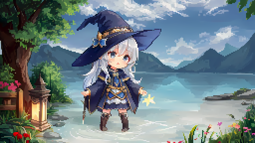
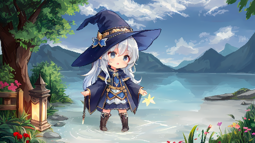
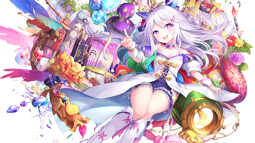
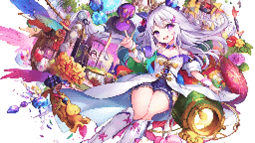
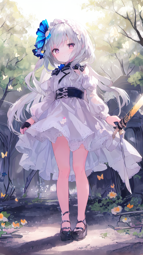
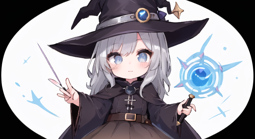
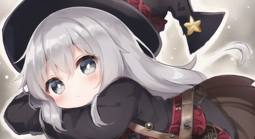

In [22]:
# @markdown <hr>

# @markdown ##Inferencing area!
# @markdown <hr>

# @markdown #🤔Inference Area


## User Inputs

model_path = "/content/bbbb/swinv2/model.onnx" # @param{type:"string"}
img_dir = "/content/aaaa" # @param{type:"string"}
preview_img_size = 255 # @param{type:"number"}

## User Inputs End

import onnxruntime as rt
import numpy as np
import os
from icecream import ic

# initialize
model = rt.InferenceSession(model_path)
if img_dir.endswith(("/", "\\")):
    img_dir = img_dir[:-1]

# get files
img_path_list, img_filename_list = get_img_list(img_dir)
embeddings = []
for i in range(len(img_path_list)):
    emb_txt = img_dir + "/" + f"{img_filename_list[i]}.npy"
    
    if os.path.exists(emb_txt):
      embedding = np.load(emb_txt)
    else:
      embedding = calc_embedding(img_path_list[i], model)
      np.save(emb_txt, embedding)
    
    embeddings.append(embedding)

# print embeddings
for i in range(len(img_path_list)):
    ic(embeddings[i])
    ic(embeddings[i].shape[1])

#plot_matrix(embeddings, img_filename_list)

ic(embedding[0].ndim)

plot_matrix(embeddings, sorted(img_path_list), urls_list, preview_img_size)